In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
assert pyro.__version__.startswith('1.8.1')
smoke_test = ('CI' in os.environ)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()[-20:]
x = torch.tensor(df["Close"]).float()[-20:]
df[:2]

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.66,17.66,17.66,17.66,17.66,0
1,1928-01-03,17.76,17.76,17.76,17.76,17.76,0


In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));

Error: Canceled future for execute_request message before replies were done

In [ ]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

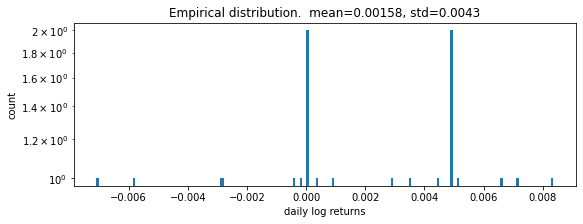

In [38]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r.numpy(), bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()));

In [39]:
def model(data):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(data.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h).to_event(1),
                obs=data)

In [40]:
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})

from Guides.ToeplitzMultivariate import ToeplitzMultivariateNorm

In [41]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 1001
optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
guide = ToeplitzMultivariateNorm(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses))
pyplot.ylim(min(losses), 20)

step 0 loss = 171.39
step 50 loss = 10833
step 100 loss = 37.0262
step 150 loss = 34.2724
step 200 loss = 34.0118
step 250 loss = 1.34281e+08
step 300 loss = 11.0595
step 350 loss = 11.7447
step 400 loss = 10.6802
step 450 loss = 2.23725e+09
step 500 loss = 182.116
step 550 loss = 11.1069
step 600 loss = 1591.31
step 650 loss = 290.769


KeyboardInterrupt: 